In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from pylib.draw_nn import draw_neural_net_fig

tf.debugging.set_log_device_placement(True)

In [3]:
## THIS OPTION ALLOWS TF TO GROW VRAM ON THE GPU
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)


## THIS OPTION CONFIGURES THE VRAM AVAILABLE FOR TF UP-FRONT
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


<!-- requirement: pylib/__init__.py -->
<!-- requirement: pylib/draw_nn.py -->
<!-- requirement: pylib/tf_utils.py -->
<!-- requirement: pylib/mnist_dataset.py -->
<!-- requirement: images/dnn_overfit.png -->
<!-- requirement: images/dnn_reg.png -->
<!-- requirement: images/dnn_dropout.png -->
<!-- requirement: images/dnn_batch.png -->
<!-- requirement: pylib/tensorboardcmd.py -->

# Deep Neural Networks


## What is deep learning?


Deep learning is a branch of machine learning that tries to emulate the biological structure and function of the brain using artificial neural networks. These networks include: 

- Multilayer Perceptron Networks
- Convolutional Neural Networks
- Recurrent Neural Networks

Additionally, these networks are hierarchical or multilayered, enabling them to model high-level abstractions in data. For this reason, deep learning is also called **hierarchical learning**. (Notice how there are two hidden layers in the figure of the multilayer perceptron network below.)

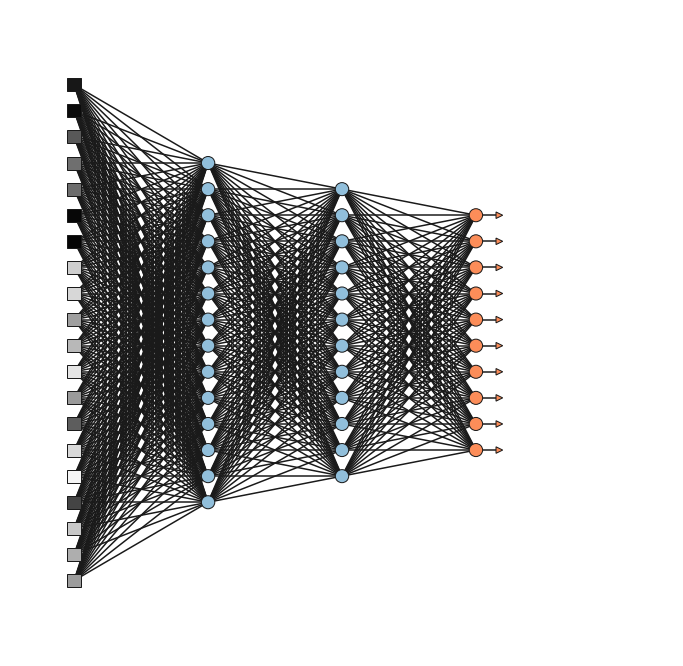

In [4]:
draw_neural_net_fig([20, 14, 12, 10])

There are benefits to using hierarchical models. In contrast to the performance of older machine learning algorithms, the performance of deep learning algorithms scales with the amount of data they are trained on -- the more data, the better the model. Consequently, deep learning algorithms typically outperform traditional ones. These models also have the ability to automatically extract features from data in a process called [feature learning](https://en.wikipedia.org/wiki/Feature_learning). This ability eliminates the need for a priori knowledge of the data to construct features, which is particularly useful when dealing with complex data such as images.  

Deep learning has some pretty neat applications. Not only can we classify images with a high degree of accuracy, but we can also use deep learning algorithms to [generate captions](https://research.googleblog.com/2016/09/show-and-tell-image-captioning-open.html), [summarize](https://research.googleblog.com/2016/08/text-summarization-with-tensorflow.html) and [translate](https://research.googleblog.com/2016/09/a-neural-network-for-machine.html) text, [generate audio](https://deepmind.com/blog/wavenet-generative-model-raw-audio/), and [produce art](https://github.com/lengstrom/fast-style-transfer/). 


## Keras API


The `DenseNeuralNetwork` class we defined in the [Basic Neural Networks notebook](TF_Basic_Neural_Networks.ipynb) only allows very limited customization of the architecture: the number and shape of each layer. However, we may want to specify different initializers, activation functions, regularizers, etc. on a layer-by-layer basis. We may also wish to experiment with using different optimizers or loss functions.

Setting up all of this using the low-level TensorFlow mechanics we've used so far will get tedious. To address this, TensorFlow provides a two higher level APIs to make creating neural networks easier, namely the [Estimator API](https://www.tensorflow.org/guide/estimators) and [Keras](https://www.tensorflow.org/api_docs/python/tf/keras).

[Keras](https://keras.io/) is actually a high-level API that allows you to write code that will run on top of TensorFlow, [Theano](https://github.com/Theano/Theano), or [CNTK](https://github.com/Microsoft/cntk).  While Keras started as a third-party solution, TensorFlow added first-class support for the Keras API, and Keras is now the native high-level API for TensorFlow.

Keras provides [layer functions](https://keras.io/layers/core/), which let us create individual layers with a single line. Let's recreate this two-layer network using Keras' [sequential API](https://keras.io/models/sequential/).  We start by creating a `Sequential` object, which acts as a container for the rest of the model.

In [5]:
from pylib.tf_utils import mnist_train, mnist_test

X_train, y_train = mnist_train()
X_test, y_test = mnist_test()

N_PIXELS= 28 * 28
N_CLASSES = 10

hidden_size = 64

Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Iter

In [6]:
model = keras.models.Sequential()

We have been using **dense** layers.  That is, each neuron is connected to all of the inputs to the layer.  First we add the hidden layer to the model:

In [7]:
model.add(
    keras.layers.Dense(
        hidden_size,
        activation='sigmoid',
        use_bias=True,  # The default
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=N_PIXELS**-0.5)
    )
)

This sets up a weight matrix (referred to as the **kernel**, for reasons to be discussed later) of `input_dim` $\times$ `hidden_size`, multiplies it with the input, adds a bias term (since `use_bias=True`), and sends the result through the sigmoid activation function.  We use a truncated normal `initializer` for the weights as before (explained in more detail below).

We use a second dense layer to produce the final output.

In [8]:
model.add(
    keras.layers.Dense(
        10,
        activation='softmax',
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=hidden_size**-0.5)
    )
)

Note that the output for each observation is 10 dimensional while each label is a single number. We dealt with this before by building one-hot encoding into our loss function. Here we'll manually one-hot encode the labels instead.

In [9]:
from tensorflow.keras.utils import to_categorical as one_hot

y_train_hot = one_hot(y_train)
y_test_hot  = one_hot(y_test)

The training process is simpler to code in Keras since the lower level details are handled for us.  We simply specify the loss function, optimization algorithm, and reporting metrics that define the training process.

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.5),
              metrics=['accuracy'])

Then we use the `.fit` method to train the model. 

In [11]:
history = model.fit(X_train, y_train_hot,
                    epochs=5,
                    batch_size=30,
                    validation_data=(X_test,y_test_hot))

Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/rep

Note that successive calls of the `.fit` method will perform additional training steps without resetting any model parameters. (Like `.partial_fit` in Scikit-learn)   

The output is a history object which contains the metric values reported during training. It's often helpful to plot these to visualize how training is progressing.  

However, you should be aware that **Keras does not report training and validation metrics in the same way**. Validation metrics are computed once at the end of each epoch, but training metrics are computed once for each batch and then averaged over the epoch. This is similar in effect to applying a time lag (of $0.5$ epochs) to the training metrics. The resulting distortion can be severe at the beginning of training if the model is improving rapidly, but disappears as training progresses.

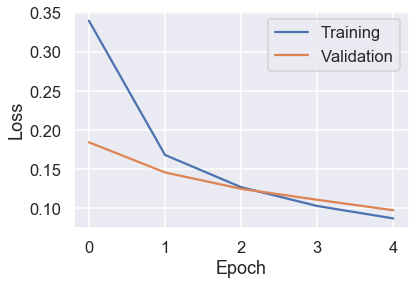

In [12]:
sns.set_context("talk")

plt.plot(history.history['loss'], label="Training")
plt.plot(history.history['val_loss'], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Of course, the trained model can also be used to make predictions. The syntax is the same as Scikit-learn, but keep in mind that our model ends with a softmax layer. This means that we'll get ten dimensional output (with probabilities corresponding to each class) for each input observation instead of a single number. If we want to actually predict labels, then we need to look at which class has the highest probability.

In [13]:
predictions = model.predict(X_test[:3])

print("Raw Predictions:\n")
print(predictions,"\n")

print("Rounded Probabilities:\n")
print(np.round(predictions,3),"\n")

print("Predicted Labels:\n")
print(np.argmax(predictions, axis=1))

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_36069 in device /job:localhost/replica:0/task:0/device:GPU:0
Raw Predictions:

[[3.65395340e-06 2.28777765e-07 7.98480105e-05 1.25623003e-04
  7.48308153e-08 1.60314794e-05 4.94051511e-09 9.99692202e-01
  5.85

This API makes it easy to add layers and neurons to neural network. However, in doing so, we run the risk of overfitting our model. 

### Initializing Weights and Biases


As a reminder, we want to initialize our weights with random values to break symmetry between neurons in a hidden layer. Additionally, we want to choose small values to avoid the **gradient vanishing problem**, where the weighted sum of the inputs (plus a bias) fall on the flat portion of the sigmoid curve. What is the proper scale of the weights?  Most of our activation functions have their best response for inputs of $\mathcal O(1)$.  If we have $m$ random inputs, each of $\mathcal O(1)$, we expect their sum to scale as $\sqrt m$.  Therefore, weights are often chosen randomly with a mean of zero and standard deviation of $1/\sqrt m$.

For very large layers, this gives rather small weights.  An alternative approach is to only provide $k < m$ non-zero weights when initializing neurons.  This scheme, known as **sparse initialization**, provides more diversity amongst the neurons at initialization.  It can, however, also produce very slow convergence as "incorrect" choices of non-zero weights have to be removed.

In the code above, we initialize our weights by sampling from a truncated normal distribution, where any weights greater than 2 standard deviations from the mean is re-picked. We also initialize the biases to zero. 

This API makes it easy to add layers and neurons to neural network. However, in doing so, we run the risk of overfitting our model. 

### Functional API

Although the sequential API has the advantage of simplicity, it is not well suited for complicated architectures involving branches. For this reason, Keras also has a [functional API](https://keras.io/getting-started/functional-api-guide/) with a more flexible syntax.

One of the main differences is that we need to define the input layer explicitly. This does not necessarily need to be an `Input` layer (it could for example be a `Flatten` layer), but it does need to specify the shape of the input data.  Keras is smart enough to take that information and figure out the required shapes for the rest of the network.  The shape that is passed into the first layer is the shape of a single observation.  For the specific purpose of neural networks, we almost always do not want to specify how many observations we will have in a particular batch of data.   

In [14]:
x = keras.layers.Input(shape=(N_PIXELS,))

Layers are created in a manner very similar to the sequential version.  These layers are then called with the input tensor as an argument.

In [15]:
hidden = keras.layers.Dense(hidden_size,
                            activation='sigmoid',
                            kernel_initializer=keras.initializers.TruncatedNormal(stddev=N_PIXELS**-0.5)
                           )(x)
                            
y = keras.layers.Dense(10,
                       activation='softmax',
                       kernel_initializer=keras.initializers.TruncatedNormal(stddev=hidden_size**-0.5)
                      )(hidden)

The last difference is that we need to create a model object that acts as a wrapper for the computation graph.

In [16]:
model = keras.models.Model(inputs=x, outputs=y)  # can use keras.Model since it's an alias

After this, the `.compile` and `.fit` methods work exactly as before.

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.5),
              metrics=['accuracy'])

history = model.fit(X_train, y_train_hot,
                    epochs=5,
                    batch_size=30,
                    validation_data=(X_test,y_test_hot))

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_36496 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __

### Subclassing `tf.keras.Model`

Another option for building models in Keras is to subclass `tf.keras.Model`. The class definition specifies the model architecture in the `__init__` method and the "forward pass" (i.e. how the model transforms an observation into a prediction) in the `call` method.

In [18]:
class SimpleModel(tf.keras.Model):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.hidden_layer = keras.layers.Dense(
            hidden_size,
            activation='sigmoid',
            kernel_initializer=keras.initializers.TruncatedNormal(stddev=N_PIXELS**-0.5)
        )
        self.prediction_layer = keras.layers.Dense(
            10,
            activation='softmax',
            kernel_initializer=keras.initializers.TruncatedNormal(stddev=hidden_size**-0.5)
        )
        
    def call(self, inputs):
        latent = self.hidden_layer(inputs)
        return self.prediction_layer(latent)

In [19]:
model = SimpleModel()
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.5),
              metrics=['accuracy'])

history = model.fit(X_train, y_train_hot,
                    epochs=5,
                    batch_size=30,
                    validation_data=(X_test,y_test_hot))

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_72227 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __

### Callbacks

The fitting methods that Keras introduces accept [callbacks](https://keras.io/callbacks/) for introducing side effects during training. One of the most useful is the `EarlyStopping` callback, which can be set to monitor a metric (usually the validation loss) to terminate training when the metric stops improving. When combined with `ModelCheckpoint` callback, this can be used to easily retrieve models in the optimal state. There are also callbacks for logging, writing to TensorBoard, and adapting the learning rate during training (note some optimizers already feature adaptive learning rates).

In [ ]:
!mkdir models

In [ ]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='./models/keras_example.hdf5',
                                               monitor='val_loss',
                                               verbose=1, save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                              verbose=1, min_delta=.01)
tensorboard = keras.callbacks.TensorBoard(log_dir='./tb/keras_demo', 
                                         histogram_freq=0, 
                                         write_graph=True, 
                                         write_images=True)

history = model.fit(X_train, y_train_hot,
                    epochs=100,
                    batch_size=30,
                    validation_data=(X_test, y_test_hot),
                    callbacks=[checkpointer, earlystopping, tensorboard]
)

## TensorBoard


[TensorBoard](https://www.tensorflow.org/get_started/summaries_and_tensorboard) is a web-based tool to help you visualize your TensorFlow graphs and runs.  While running your graphs, you write to event files.  When you launch TensorBoard, it will run a local web server with visualizations of this material. As demonstrated before, Keras offers a TensorBoard callback.

In [ ]:
from pylib.tensorboardcmd import tensorboard_cmd

tensorboard_cmd('tb/keras_demo')

Now you can launch `tensorboard`.  As the instructions above say, on a terminal in this directory, run
```bash
tensorboard --logdir=tb/keras_demo
```
This will start up a web server on port 6006.  If you are running this on your own computer, you can just visit `localhost:6006`.  On the training cloud computer, you can't access this port directly.  Instead, we've set up a proxy to forward these connections.  Use the link in the output above.

Visiting TensorBoard, you can click on the "Graphs" header to get a visualization of the computation graph.  This allows you to zoom and scroll through the graph, examining the operations and the tensors passed between them. In this case this includes nodes from the various models we've built in this notebook.

Another useful capability of TensorBoard is to keep track of some value each time a computation is run. Such quantities are called "scalars." The Keras TensorBoard callback automatically logs the loss and accuracy as scalars.

We don't make too much use of TensorBoard in these notebooks, preferring visualizations that we've integrated into the notebook.  Don't let that dissuade you from using it in your own work!

*Copyright &copy; 2019 Pragmatic Institute. This content is licensed solely for personal use. Redistribution or publication of this material is strictly prohibited.*